# Finding the completeness function for all stars in my sample
I am going to try a somewhat more opaque machine-learning model to find the detection rate as a function of primary and secondary temperature, and primary and secondary vsini. We will probably have to treat the different instruments separately, but just in that there will be different best-fit parameters.

## Update:
The machine learning model works alright for predicting what kinds of companions you can detect for a new star. However, it does poorly in the interface region where the completeness drops from 1-->0. So, I ended up using 2D interpolation to get the completeness surfaces for each of my stars.

In [1]:
from __future__ import print_function, division, absolute_import

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.cross_validation import cross_val_score
from matplotlib.cm import viridis
import sqlite3
from astropy.visualization import hist
import astropy.stats
from astropy.modeling import models, fitting
import seaborn as sns
import pickle
from scipy.interpolate import CloughTocher2DInterpolator
import warnings

sns.set_context('talk', font_scale=1.5)


%matplotlib inline

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Part 1: Machine Learning Model

In [4]:
home = os.environ['HOME']
basedir = os.path.join(home, 'School', 'Research')

inst_dirs = dict(TS23=os.path.join(basedir, 'McDonaldData'),
                 HRS=os.path.join(basedir, 'HET_data'),
                 CHIRON=os.path.join(basedir, 'CHIRON_data'),
                 IGRINS=os.path.join(basedir, 'IGRINS_data'))

# Get the observing stats (especially the S/N)
obs_stats = pd.read_csv('data/SampleObservations.csv')

# Get the binarity/multiplicity of the stars
with sqlite3.connect('{}/.PythonModules/Stellar_database/Stars.sqlite'.format(os.environ['HOME'])) as db_con:
    sql_query = """
                   SELECT name, binarity.wds_binary, binarity.sb9_binary, binarity.my_binary, binarity.separation, binarity.K1 
                   FROM star
                   INNER JOIN binarity
                   ON star.id=binarity.star_id;
                """
    binarity = pd.read_sql_query(sql_query, db_con)
binarity['known_binary'] = ((binarity.wds_binary) | (binarity.sb9_binary) | (binarity.my_binary)).astype(bool)
binary_stars = binarity.loc[binarity.known_binary, 'name'].values

def get_summary(instrument, reject_binary=False):
    summary = pd.read_csv(os.path.join(inst_dirs[instrument], 'Sensitivity_Summary.csv'), index_col=0)
    if reject_binary:
        summary = summary.loc[~summary.star.isin(binary_stars)]
    ccf_data = pd.read_csv(os.path.join(inst_dirs[instrument], 'Cross_correlations', 'CCF_primary_20151129.rv.txt'))
    ccf_data.rename(columns=dict(teff='pri_teff', logg='pri_logg', vsini='pri_vsini'), inplace=True)
    tmp = pd.merge(summary, ccf_data[['star', 'date', 'pri_teff', 'pri_logg', 'pri_vsini']], on=['star', 'date'], how='left')
    return pd.merge(tmp, obs_stats.loc[obs_stats.instrument == instrument, ['star', 'date', 'exptime', 'snr']], 
                    on=('star', 'date'), how='left')
     
def get_injection_results(instrument, reject_binary=False):
    results = pd.read_csv(os.path.join(inst_dirs[instrument], 'Sensitivity_Dataframe.csv'), index_col=0)
    if reject_binary:
        results = results.loc[~results.star.isin(binary_stars)]
    ccf_data = pd.read_csv(os.path.join(inst_dirs[instrument], 'Cross_correlations', 'CCF_primary_20151129.rv.txt'))
    ccf_data.rename(columns=dict(teff='pri_teff', logg='pri_logg', vsini='pri_vsini'), inplace=True)
    tmp = pd.merge(results, ccf_data[['star', 'date', 'pri_teff', 'pri_logg', 'pri_vsini']], on=['star', 'date'], how='left')
    return pd.merge(tmp, obs_stats.loc[obs_stats.instrument == instrument, ['star', 'date', 'exptime', 'snr']], 
                    on=('star', 'date'), how='left')
    

In [3]:
# Use CHIRON data for display and testing purposes (it has the most data)
df = get_injection_results('CHIRON', reject_binary=True)
summary = get_summary('CHIRON', reject_binary=True)
df['Detected'] = df.significance.notnull().astype(np.int)

## Find the importance of various features

Classifier score = 0.95

temperature: 0.61090919262 +/- 0.0577204577511
vsini: 0.241127824085 +/- 0.0567441895257
pri_teff: 0.0841631800395 +/- 0.0146014569717
pri_vsini: 0.0454430735073 +/- 0.0104414329235
snr: 0.0183567297477 +/- 0.00511567472809


([<matplotlib.axis.XTick at 0x7f0db2d64250>,
 <a list of 5 Text xticklabel objects>)

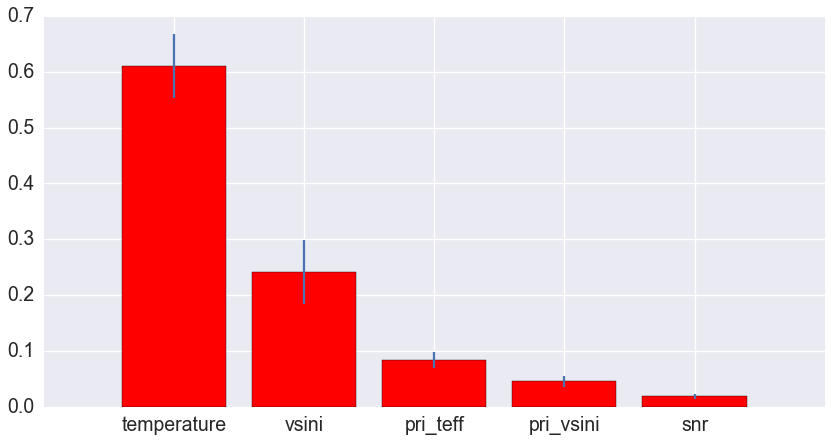

In [4]:
# Define features
features = ['pri_teff', 'temperature', 'pri_vsini', 'vsini', 'snr']
X = df.loc[df.addmode == 'simple', features].as_matrix()
y = df.loc[df.addmode == 'simple', 'Detected'].values

# Split into a training and test sample
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Fit the estimator
rf = RandomForestClassifier(n_estimators=50, max_depth=10)
rf.fit(X_train, y_train)

# Find the score on the test set
print('Classifier score = {:.2f}'.format(rf.score(X_test, y_test)))

# Show feature importance
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print('')
for f in range(X_train.shape[1]):
    print('{}: {} +/- {}'.format(features[indices[f]], importances[indices[f]], std[indices[f]]))
    
# Make a plot showing the feature importances
fig, ax = plt.subplots(1, 1, figsize=(14,7))
ax.bar(range(X_train.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(X_train.shape[1]), [features[i] for i in indices])

## Do the same thing with a pipeline

I will actually use logistic regression instead of the random forest, but they are similar...

alpha = 1e-06
alpha = 4.64158883361e-06
alpha = 2.15443469003e-05
alpha = 0.0001
alpha = 0.000464158883361
alpha = 0.00215443469003
alpha = 0.01
alpha = 0.0464158883361
alpha = 0.215443469003
alpha = 1.0
Setting alpha = 0.000464158883361
Classifier score = 0.94


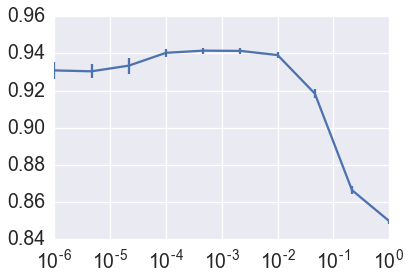

In [5]:
cross_validate = True
classifier = 'SGD'

# Define features
features = ['temperature', 'pri_teff', 'vsini', 'pri_vsini', 'snr']
X = df.loc[df.addmode == 'simple', features].as_matrix()
y = df.loc[df.addmode == 'simple', 'Detected'].values

# Split into a training and test sample
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Fit the estimator
if classifier == 'SGD':
    clf = SGDClassifier(loss='log', alpha=0.001)
elif classifier == 'RF':
    clf = RandomForestClassifier(n_estimators=150, max_depth=10)
#clf = LogisticRegressionCV(Cs=20)
#clf = LinearSVC()

clf = CalibratedClassifierCV(clf, method='isotonic')
steps = [('Normalize', StandardScaler()), ('poly', PolynomialFeatures(2)), ('clf', clf)]
pipe = Pipeline(steps)

if cross_validate:
    # Cross-validate the SGD alpha parameter
    mean_score = []
    std_score = []
    if classifier == 'SGD':
        alphas = np.logspace(-6, 0, 10)
    elif classifier == 'RF':
        alphas = np.linspace(1, 300, 10, dtype=np.int)
    for alpha in alphas:
        print('alpha = {}'.format(alpha))
        if classifier == 'SGD':
            pipe.set_params(clf__base_estimator__alpha=alpha)
        else:
            pipe.set_params(clf__base_estimator__max_depth=alpha)
        scores = cross_val_score(pipe, X_train, y_train, cv=8, n_jobs=-1)
        mean_score.append(np.mean(scores))
        std_score.append(np.std(scores))

    plt.errorbar(alphas, mean_score, yerr=std_score)
    if classifier == 'SGD':
        ax = plt.gca()
        ax.set_xscale('log')

    # Set to the best value
    best_alpha = alphas[np.argmax(mean_score)]
    print('Setting alpha = {}'.format(best_alpha))
    if classifier == 'SGD':
        pipe.set_params(clf__base_estimator__alpha=best_alpha)
    elif classifier == 'RF':
        pipe.set_params(clf__base_estimator__max_depth=best_alpha)
    
pipe.fit(X_train, y_train)

# Find the score on the test set
print('Classifier score = {:.2f}'.format(pipe.score(X_test, y_test)))

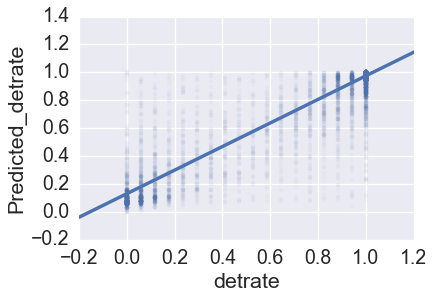

In [6]:
#pipe.set_params(clf__base_estimator__alpha=0.01)
X_summary = summary.loc[summary.addmode == 'simple', features]
if hasattr(pipe, "predict_proba"):
    prediction = pipe.predict_proba(X_summary)[:, 1]
else:  # use decision function
    prediction = pipe.decision_function(X_summary)
    prediction = \
                (prediction - prediction.min()) / (prediction.max() - prediction.min())
        
summary.loc[summary.addmode == 'simple', 'Predicted_detrate'] = prediction
sns.regplot('detrate', 'Predicted_detrate', data=summary, scatter_kws=dict(alpha=0.03))

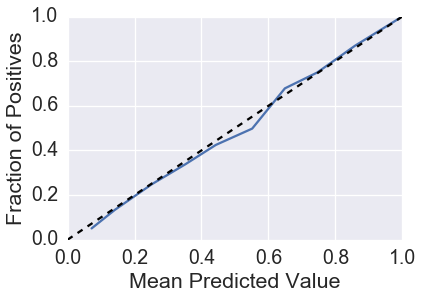

In [7]:
prob_pos = pipe.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives)
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.plot((0, 1), (0, 1), 'k--')

In [8]:
#Fit to the full dataset
pipe.fit(X, y)

Pipeline(steps=[('Normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('clf', CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.00046415888336127773, average=False, class_weight=None,
       epsilo...tate=None, shuffle=True,
       verbose=0, warm_start=False),
            cv=3, method='isotonic'))])

# Apply the fit to some stars and plot the residuals

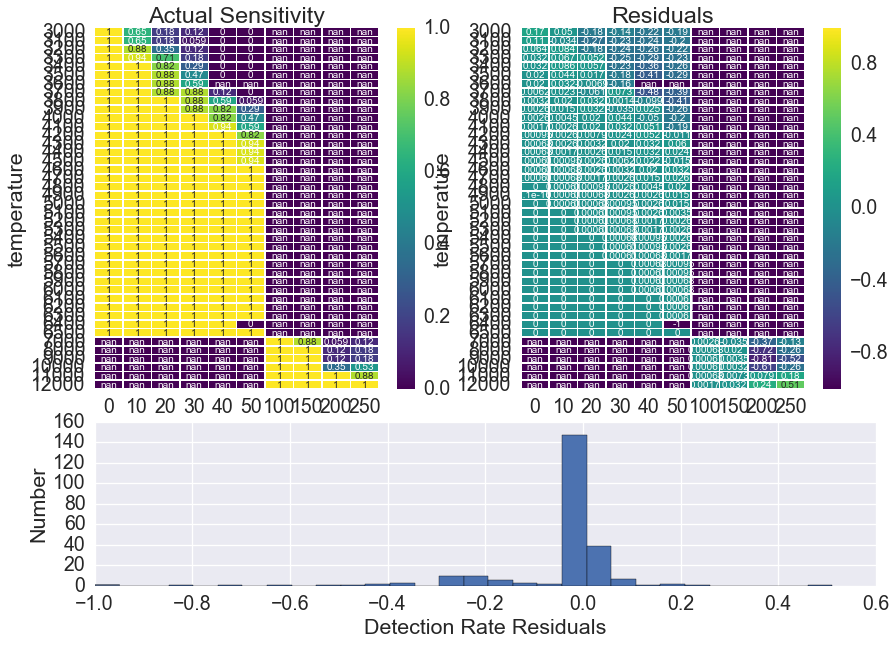

In [9]:
def plot_residuals(star, date, clf, features, addmode='simple', refit=False, **kwargs):
    if refit:
        #clf = clf.copy()
        subset = df.loc[(df.star == star) & (df.date == date) & (df.addmode == addmode)].copy()
        X = subset[features].as_matrix()
        y = subset['Detected'].values
        clf.fit(X, y)
        
    # Get predictions and residuals
    subset = summary.loc[(summary.star == star) & (summary.date == date) & (summary.addmode == addmode)].copy()
    X_summary = subset[features].as_matrix()
    if hasattr(clf, "predict_proba"):
        prediction = clf.predict_proba(X_summary)[:, 1]
    else:  # use decision function
        prediction = clf.decision_function(X_summary)
        prediction = \
                    (prediction - prediction.min()) / (prediction.max() - prediction.min())
    subset['prediction'] = prediction
    subset['diff'] = subset.detrate - subset.prediction
    
    # make figure
    fig = plt.figure(figsize=(14, 10))
    left = plt.subplot2grid((3, 2), (0, 0), rowspan=2)
    right = plt.subplot2grid((3, 2), (0, 1), rowspan=2)
    bottom = plt.subplot2grid((3, 2), (2, 0), colspan=2)
    
    # Plot 2d sensitivity curves
    #Sensitivity.heatmap(subset[['temperature', 'vsini', 'detrate']], ax=left, **kwargs)
    #Sensitivity.heatmap(subset[['temperature', 'vsini', 'diff']], ax=right, **kwargs)
    sns.heatmap(subset.pivot('temperature', 'vsini', 'detrate'), ax=left, annot=True, **kwargs)
    sns.heatmap(subset.pivot('temperature', 'vsini', 'diff'), ax=right, annot=True, **kwargs)
    left.set_title('Actual Sensitivity')
    right.set_title('Residuals')
    
    # Plot residual histogram
    residuals = subset.loc[subset['diff'].notnull(), 'diff'].values
    hist(residuals, bins=30)
    #bottom.set_yscale('log')
    #ylim = bottom.get_ylim()
    #bottom.set_ylim((0.5, ylim[1]))
    bottom.set_xlabel('Detection Rate Residuals')
    bottom.set_ylabel('Number')
    return 

star = 'HIP 93580'
date = summary.loc[summary.star == star].date.unique()[0]
residuals = plot_residuals(star, date, pipe, features, cmap=viridis, refit=False)


## Do the completeness curves look reasonable?

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/utils/validation.py:498: UserWarning: StandardScaler assumes floating point values as input, got int64
  "got %s" % (estimator, X.dtype))


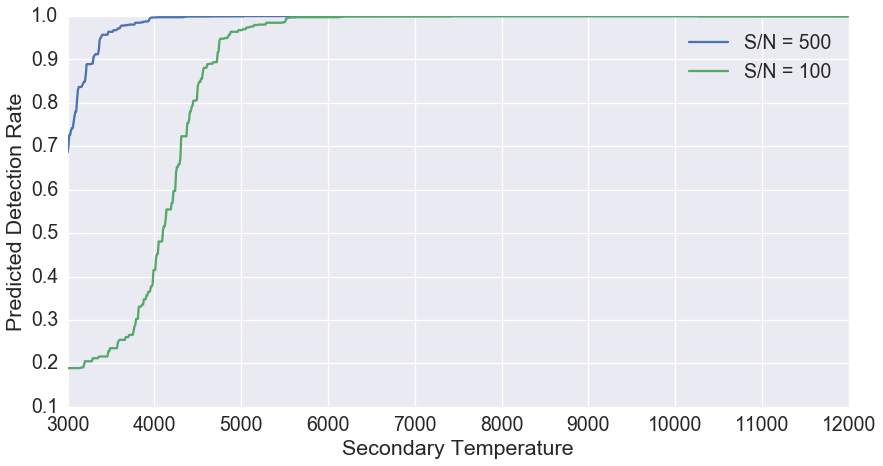

In [10]:
def get_detrate(T2_vals, T1=10000, v1sini=100, v2sini=10.0, snr=500):
    T1_vals = np.ones_like(T2_vals) * T1
    v1sini_vals = np.ones_like(T2_vals) * v1sini
    v2sini_vals = np.ones_like(T2_vals) * v2sini
    snr_vals = np.ones_like(T2_vals) * snr
    X_tmp = np.vstack((T2_vals, T1_vals, v2sini_vals, v1sini_vals, snr_vals)).T
    y_tmp = pipe.predict_proba(X_tmp)[:, 1]
    return y_tmp

T2_vals = np.arange(3000, 12000, 10)
y1 = get_detrate(T2_vals, v2sini=0)
y2 = get_detrate(T2_vals, v2sini=50)
fig, ax = plt.subplots(1, 1, figsize=(14,7))
plt.plot(T2_vals, y1, label='S/N = 500')
plt.plot(T2_vals, y2, label='S/N = 100')
plt.legend(loc='best', fancybox=True)
plt.xlabel('Secondary Temperature')
plt.ylabel('Predicted Detection Rate')

# Conclusions:
It definitely gets the shape of the curve right, and reacts to all the parameters in the right way. The only issue is doesn't too very well in the transition region from detection rate = 1 --> 0. Moving on to...

# 2D Interpolation

In [33]:
@models.custom_model
def sigmoid(x, alpha=-0.2, beta=20):
    f = alpha*(x-beta)
    return 1.0/(1+np.exp(-f))

def fit_sigmoid(x, y):
    m_init = sigmoid()
    f = fitting.LevMarLSQFitter()
    with warnings.catch_warnings():
        warnings.simplefilter('error')
        m = f(m_init, x, y, maxiter=10000)
    return m

#from itertools import cycle
#colors = cycle(('red', 'blue', 'green', 'black'))
def get_data(star, date, addmode='simple', extend_highT=True, extend_highvsini=True):
    subset = summary.loc[(summary.star == star) & 
                         (summary.date == date) & 
                         (summary.addmode == addmode)].dropna(subset=('detrate',))
    
    # Add some points at low vsini and high temperature (always detected)
    if extend_highT:
        highT = np.arange(7000, 12100, 200)
        tmp = pd.DataFrame(data=dict(temperature=highT, detrate=np.ones_like(highT)))
        for vsini in [0, 10, 20, 30, 40, 50]:
            idx = np.argmax(subset.loc[subset.vsini == vsini, 'temperature'])
            if subset.loc[idx, 'detrate'] == 1.0:
                tmp['vsini'] = vsini
                subset = pd.concat((subset, tmp))
    
    # Now, add some points at high vsini and low temperature (never detected)
    if extend_highvsini:
        high_vsini = np.arange(75, 250+25, 25)
        tmp = pd.DataFrame(data=dict(vsini=high_vsini, detrate=np.zeros_like(high_vsini)))
        for teff in range(3000, 7000, 100):
            if teff in subset.temperature.unique():
                idx = np.argmax(subset.loc[subset.temperature == teff, 'vsini'])
            else:
                continue
            if subset.loc[idx, 'detrate'] == 0.0:
                tmp['temperature'] = teff
                tmp['detrate'] = 0.0
                subset = pd.concat((subset, tmp))
            elif subset.loc[idx, 'detrate'] < 0.5:
                vsini = subset.loc[subset.temperature == teff, 'vsini']
                detrate = subset.loc[subset.temperature == teff, 'detrate']
                try:
                    sigmoid_fcn = fit_sigmoid(vsini.values, detrate.values)
                except:
                    continue

                tmp['temperature'] = teff
                tmp['detrate'] = sigmoid_fcn(tmp['vsini'])
                subset = pd.concat((subset, tmp))
                #col = colors.next()
                #plt.scatter(vsini, detrate, c=col)
                #plt.plot(vsini, sigmoid_fcn(vsini), color=col)
            else:
                break
    return subset

In [103]:
# Test out on a random star
star = summary.star.unique()[1]
star = 'HIP 106786'
date = summary.loc[summary.star == star, 'date'].unique()[0]
print(date)
subset = get_data(star=star, date=date, extend_highvsini=False)

#subset = subset.loc[subset.temperature < 7000]
X = subset[['temperature', 'vsini']].as_matrix()
y = subset['detrate'].values

2014-10-15


In [108]:
def get_interpolator(X, y, rescale=True):
    """ Get an interpolator from the (2D) X points to the y points """
    # Rescale X to unit cube
    if rescale:
        maximum = np.max(X, axis=0)
        minimum = np.min(X, axis=0)
    else:
        minimum = np.zeros(2)
        maximum = np.ones(2)
    X = (X - minimum) / (maximum - minimum)

    # Interpolate
    s = Rbf(X[:, 0], X[:, 1], y, function='linear')
    
    def interpolator(xval, yval):
        # Rescale:
        xval = (xval - minimum[0]) / (maximum[0] - minimum[0])
        yval = (yval - minimum[1]) / (maximum[1] - minimum[1])
        return s(xval, yval)
    
    return s, minimum, maximum, interpolator

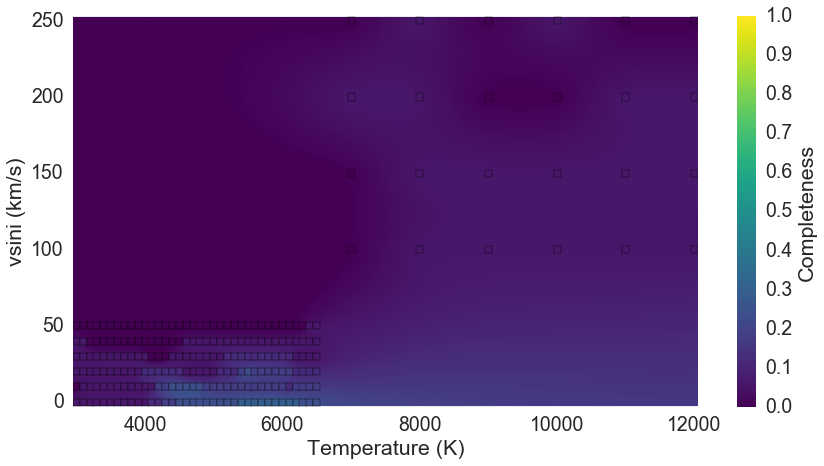

In [109]:
X = subset[['temperature', 'vsini']].as_matrix()
y = subset['detrate'].values

xx = np.linspace(3000, 12000, num=200)
yy = np.linspace(0, 250, num=200)
XX, YY = np.meshgrid(xx, yy)
test_pts = np.array((XX, YY)).reshape(2, -1).T



# Interpolate
#s = CloughTocher2DInterpolator(X, y, rescale=True)
rbf_interpolator, minimum, maximum, s = get_interpolator(X, y, rescale=True)
mu = s(test_pts[:, 0], test_pts[:, 1])


# Plot
fig, (ax) = plt.subplots(1, 1, figsize=(14, 7))
im = ax.scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', 
                        cmap=viridis, vmin=0, vmax=1)
im = ax.scatter(X[:, 0], X[:, 1], c=y, s=50, marker='s', cmap=viridis, vmin=0, vmax=1)
cax = plt.colorbar(im, ax=ax)
ax.set_xlim((2950, 12050))
ax.set_ylim((-3, 253))
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('vsini (km/s)')
cax.set_label('Completeness')

In [115]:
# Interpolate the completeness for every star.
output_dir = 'Completeness/New/CHIRON'
summary = get_summary('CHIRON', reject_binary=False)
for star in summary.star.unique():
    for date in summary.loc[summary.star == star, 'date'].unique():
        print('Star={}\nDate={}\n'.format(star, date))
        if '{}/{}_{}.pkl'.format(output_dir, 
                                        star.replace(' ', '_'), 
                                        date.replace('-', '')) in os.listdir(output_dir):
            continue
        # Get the data (supplemented with some assumption about the shape of the surface)
        subset = get_data(star=star, date=date)
        X = subset[['temperature', 'vsini']].as_matrix()
        y = subset['detrate'].values
        
        # Interpolate
        #s = CloughTocher2DInterpolator(X, y, rescale=True)
        rbf_interpolator, minimum, maximum, s = get_interpolator(X, y, rescale=True)
        
        # Calculate the completeness on a large grid
        xx = np.linspace(3000, 12000, num=200)
        yy = np.linspace(0, 250, num=200)
        XX, YY = np.meshgrid(xx, yy)
        test_pts = np.array((XX, YY)).reshape(2, -1).T
        mu = s(test_pts[:, 0], test_pts[:, 1])

        # Plot
        fig, ax = plt.subplots(1, 1, figsize=(14, 7))
        im = ax.scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', 
                                cmap=viridis, vmin=0, vmax=1)
        im = ax.scatter(X[:, 0], X[:, 1], c=y, s=50, marker='s', cmap=viridis, vmin=0, vmax=1)
        cax = plt.colorbar(im, ax=ax)
        ax.set_xlim((2950, 12050))
        ax.set_ylim((-3, 253))
        ax.set_xlabel('Temperature (K)')
        ax.set_ylabel('vsini (km/s)')
        cax.set_label('Completeness')
        
        # Save the interpolator and the figure
        fig.savefig('{}/{}_{}.pdf'.format(output_dir, 
                                          star.replace(' ', '_'), 
                                          date.replace('-', '')))
        plt.close('all')
        with open('{}/{}_{}.pkl'.format(output_dir, 
                                        star.replace(' ', '_'), 
                                        date.replace('-', '')), 'w') as outfile:
            dill.dump(s, outfile)
        

Star=HIP 100881
Date=2013-08-07

Star=HIP 101589
Date=2013-06-05

Star=HIP 101867
Date=2013-07-16

Star=HIP 10320
Date=2013-08-28

Star=HIP 103298
Date=2015-05-13

Star=HIP 104019
Date=2013-07-01

Star=HIP 104139
Date=2013-06-05

Star=HIP 105140
Date=2013-07-12

Star=HIP 106786
Date=2014-05-17

Star=HIP 107517
Date=2014-08-04

Star=HIP 107608
Date=2014-05-11

Star=HIP 108294
Date=2014-05-13

Star=HIP 109139
Date=2013-06-04

Star=HIP 109139
Date=2013-08-20

Star=HIP 110838
Date=2013-09-08

Star=HIP 110838
Date=2014-08-11

Star=HIP 110935
Date=2014-08-27

Star=HIP 112029
Date=2013-07-14

Star=HIP 112029
Date=2014-08-23

Star=HIP 11345
Date=2014-08-25

Star=HIP 114822
Date=2014-08-15

Star=HIP 114822
Date=2014-08-17

Star=HIP 115115
Date=2014-05-20

Star=HIP 115115
Date=2015-05-21

Star=HIP 116247
Date=2013-06-20

Star=HIP 116971
Date=2013-07-14

Star=HIP 116971
Date=2013-09-20

Star=HIP 116971
Date=2014-07-31

Star=HIP 116971
Date=2014-10-06

Star=HIP 117089
Date=2013-08-09

Star=HIP 117

# Now, do the other instruments


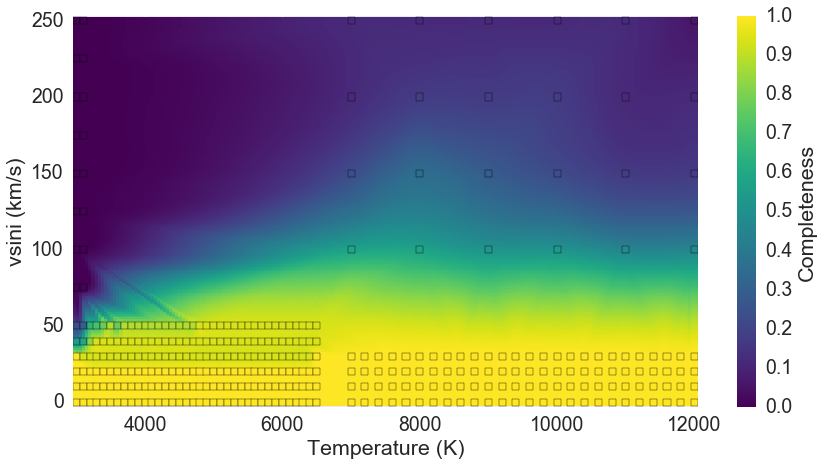

In [37]:
instrument = 'IGRINS'
summary = get_summary(instrument)

# Test out on a random star
star = summary.star.unique()[1]
date = summary.loc[summary.star == star, 'date'].unique()[0]
subset = get_data(star=star, date=date)

#subset = subset.loc[subset.temperature < 7000]
X = subset[['temperature', 'vsini']].as_matrix()
y = subset['detrate'].values

xx = np.linspace(3000, 12000, num=200)
yy = np.linspace(0, 250, num=200)
XX, YY = np.meshgrid(xx, yy)
test_pts = np.array((XX, YY)).reshape(2, -1).T

# Interpolate
s = CloughTocher2DInterpolator(X, y, rescale=True)
mu = s(test_pts[:, 0], test_pts[:, 1])

# Plot
fig, (ax) = plt.subplots(1, 1, figsize=(14, 7))
im = ax.scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', 
                        cmap=viridis, vmin=0, vmax=1)
im = ax.scatter(X[:, 0], X[:, 1], c=y, s=50, marker='s', cmap=viridis, vmin=0, vmax=1)
cax = plt.colorbar(im, ax=ax)
ax.set_xlim((2950, 12050))
ax.set_ylim((-3, 253))
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('vsini (km/s)')
cax.set_label('Completeness')

In [120]:
for inst in ['IGRINS']:

    output_dir = 'Completeness/New/{}'.format(inst)
    summary = get_summary(inst, reject_binary=False)
    for star in summary.star.unique():
        for date in summary.loc[summary.star == star, 'date'].unique():
            #if star not in bad_stars or date not in bad_dates:
            #    continue
            # Get the data (supplemented with some assumption about the shape of the surface)
            #extend = False if inst == 'IGRINS' else True
            #subset = get_data(star=star, date=date, extend_highvsini=extend)
            print(star, date)
            subset = get_data(star=star, date=date, extend_highvsini=True)
            if subset.duplicated(subset=('temperature', 'vsini')).sum() > 0:
                subset = get_data(star=star, date=date, extend_highvsini=False)
            X = subset[['temperature', 'vsini']].as_matrix()
            y = subset['detrate'].values

            # Interpolate
            #s = CloughTocher2DInterpolator(X, y, rescale=True)
            rbf_interpolator, minimum, maximum, s = get_interpolator(X, y, rescale=True)

            # Calculate the completeness on a large grid
            xx = np.linspace(3000, 12000, num=200)
            yy = np.linspace(0, 250, num=200)
            XX, YY = np.meshgrid(xx, yy)
            test_pts = np.array((XX, YY)).reshape(2, -1).T
            mu = s(test_pts[:, 0], test_pts[:, 1])

            # Plot
            fig, ax = plt.subplots(1, 1, figsize=(14, 7))
            im = ax.scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', 
                                    cmap=viridis, vmin=0, vmax=1)
            im = ax.scatter(X[:, 0], X[:, 1], c=y, s=50, marker='s', cmap=viridis, vmin=0, vmax=1)
            cax = plt.colorbar(im, ax=ax)
            ax.set_xlim((2950, 12050))
            ax.set_ylim((-3, 253))
            ax.set_xlabel('Temperature (K)')
            ax.set_ylabel('vsini (km/s)')
            cax.set_label('Completeness')

            # Save the interpolator and the figure
            fig.savefig('{}/{}_{}.pdf'.format(output_dir, 
                                              star.replace(' ', '_'), 
                                              date.replace('-', '')))
            plt.close('all')
            with open('{}/{}_{}.pkl'.format(output_dir, 
                                            star.replace(' ', '_'), 
                                            date.replace('-', '')), 'w') as outfile:
                dill.dump(s, outfile)

ADS 3962 AB 2014-10-16
HIP 100907 2014-10-16
HIP 101123 2014-10-15
HIP 101909 2014-10-15
HIP 103298 2014-10-16
HIP 104105 2014-10-15
HIP 105891 2014-10-16
HIP 106786 2014-10-15
HIP 10732 2014-10-15
HIP 10732 2015-03-02
HIP 108339 2014-10-15
HIP 109056 2014-10-15
HIP 109056 2014-10-16
HIP 109056 2014-10-17
HIP 109056 2014-10-18
HIP 109521 2014-10-15
HIP 109831 2014-10-15
HIP 111056 2014-10-15
HIP 116611 2014-10-16
HIP 116631 2014-10-16
HIP 118243 2014-10-15
HIP 12332 2014-10-17
HIP 12706 2014-10-16
HIP 12803 2014-10-17
HIP 13879 2014-10-15
HIP 14764 2014-10-16
HIP 14862 2014-10-15
HIP 14862 2015-03-03
HIP 15110 2014-10-16
HIP 16210 2014-10-15
HIP 16244 2014-10-15
HIP 16322 2014-10-16
HIP 16599 2014-10-15
HIP 16611 2014-10-16
HIP 17527 2014-10-17
HIP 19949 2014-10-15
HIP 19949 2015-03-03
HIP 20380 2014-10-15
HIP 20380 2015-03-03
HIP 20542 2014-10-17
HIP 20789 2014-10-16
HIP 21589 2014-10-18
HIP 21683 2014-10-18
HIP 22028 2014-10-17
HIP 22833 2014-10-16
HIP 23362 2014-10-16
HIP 23916 2014

# Fix a couple bad observations

There are a couple bad observations that don't interpolate well. For many of them, I just need to run a few more injection/recovery tests. Some have an anomalous detection rate of 0 surrounded by detection rates of 1.

## 1. Fix bad detection rates in some of the CHIRON data.

Not sure how this happened, but the detection rate should be 1, not 0. I'll go ahead and fix that, and then redo the interpolation.

In [117]:
summary = get_summary('CHIRON', reject_binary=False)
bad_hipnums = (3741,70915,85922,22509,70915,71974,79005,93580,95619,103298,115115,85537,85922)
bad_stars = ['HIP {}'.format(n) for n in bad_hipnums]
bad_dates = ('20150601','20150309','20150322','20150414','20150424','20150225','20150309','20150404','20150406',
             '20150513','20150521','20150315','20150322')
bad_dates = ['{}-{}-{}'.format(d[:4], d[4:6], d[6:]) for d in bad_dates]
summary.loc[(summary.star == bad_stars[0]) & (summary.date == bad_dates[0]) & (summary.temperature == 6400), ['star', 'date', 'addmode', 'temperature', 'vsini', 'detrate']]

,star,date,addmode,temperature,vsini,detrate
61078,HIP 3741,2015-06-01,dc,6400,0,1
61079,HIP 3741,2015-06-01,dc,6400,10,1
61080,HIP 3741,2015-06-01,dc,6400,20,1
61081,HIP 3741,2015-06-01,dc,6400,30,1
61082,HIP 3741,2015-06-01,dc,6400,40,1
61083,HIP 3741,2015-06-01,dc,6400,50,0
61316,HIP 3741,2015-06-01,ml,6400,0,1
61317,HIP 3741,2015-06-01,ml,6400,10,1
61318,HIP 3741,2015-06-01,ml,6400,20,1
61319,HIP 3741,2015-06-01,ml,6400,30,1


In [118]:
output_dir = 'Completeness/New/CHIRON'
for star, date in zip(bad_stars, bad_dates):
        print(star, date)
        for addmode in ['simple', 'dc', 'ml']:
            summary.loc[(summary.star == star) & (summary.date == date) & (summary.addmode == addmode) &
                        (summary.temperature == 6400) & (summary.vsini == 50), 'detrate'] = 1.0
        
        # Get the data (supplemented with some assumption about the shape of the surface)
        subset = get_data(star=star, date=date)
        X = subset[['temperature', 'vsini']].as_matrix()
        y = subset['detrate'].values
        
        # Interpolate
        #s = CloughTocher2DInterpolator(X, y, rescale=True)
        rbf_interpolator, minimum, maximum, s = get_interpolator(X, y, rescale=True)
        
        # Calculate the completeness on a large grid
        xx = np.linspace(3000, 12000, num=200)
        yy = np.linspace(0, 250, num=200)
        XX, YY = np.meshgrid(xx, yy)
        test_pts = np.array((XX, YY)).reshape(2, -1).T
        mu = s(test_pts[:, 0], test_pts[:, 1])

        # Plot
        fig, ax = plt.subplots(1, 1, figsize=(14, 7))
        im = ax.scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', 
                                cmap=viridis, vmin=0, vmax=1)
        im = ax.scatter(X[:, 0], X[:, 1], c=y, s=50, marker='s', cmap=viridis, vmin=0, vmax=1)
        cax = plt.colorbar(im, ax=ax)
        ax.set_xlim((2950, 12050))
        ax.set_ylim((-3, 253))
        ax.set_xlabel('Temperature (K)')
        ax.set_ylabel('vsini (km/s)')
        cax.set_label('Completeness')
        
        # Save the interpolator and the figure
        fig.savefig('{}/{}_{}.pdf'.format(output_dir, 
                                          star.replace(' ', '_'), 
                                          date.replace('-', '')))
        plt.close('all')
        with open('{}/{}_{}.pkl'.format(output_dir, 
                                        star.replace(' ', '_'), 
                                        date.replace('-', '')), 'w') as outfile:
            dill.dump(s, outfile)

HIP 3741 2015-06-01
HIP 70915 2015-03-09
HIP 85922 2015-03-22
HIP 22509 2015-04-14
HIP 70915 2015-04-24
HIP 71974 2015-02-25
HIP 79005 2015-03-09
HIP 93580 2015-04-04
HIP 95619 2015-04-06
HIP 103298 2015-05-13
HIP 115115 2015-05-21
HIP 85537 2015-03-15
HIP 85922 2015-03-22


## Rerun some stars with additional injection/recovery results

I managed to outright miss a bunch of stars in the high temperature extension to my sensitivity analysis. In addition, I am running a few low temperature and high vsini experiments in IGRINS data, because some stars have very high detection rates even at 3000 K and 50 km/s!

In [19]:
# Make lists of all of the observations that need to be redone
CHIRON_badnums = (116247, 106786, 77858, 58590, 88290)
CHIRON_baddates = ('20130620', '20140517', '20140317', '20130215', '20140804')

TS23_badnums = (113788,106786,98194,98055,65477,22840,16147,3300,
                1366,44127,33372,28691,26563,25281,25048,12719,2912)
TS23_baddates = ('20131021', '20141101', '20131018', '20131021', '20140112', '20140121', '20130107', '20130107',
                 '20131020', '20141020', '20141020', '20130106', '20140120', '20130107', '20130107',
                 '20131018', '20131018')

HRS_badnums = (100221,92027,81641,92728,89156,15338)
HRS_baddates = ('20130819', '20130423', '20130422', '20130423', '20140423', '20130819')

IGRINS_badnums = (106786,85922,85537,68092,42090,89935,89935,72552,62576,27713,16599,5626,13879,78821,8704)
IGRINS_baddates = ('20141015','20150427','20140710','20150427','20150412','20141015',
                   '20140710','20150412','20150410','20141016','20141015','20141015','20141015',
                   '20150427', '20150303')

bad_stars = dict(CHIRON=['HIP {}'.format(n) for n in CHIRON_badnums],
                 TS23=['HIP {}'.format(n) for n in TS23_badnums],
                 HRS=['HIP {}'.format(n) for n in HRS_badnums],
                 IGRINS=['HIP {}'.format(n) for n in IGRINS_badnums])
bad_dates = dict(CHIRON=['{}-{}-{}'.format(d[:4], d[4:6], d[6:]) for d in CHIRON_baddates],
                 TS23=['{}-{}-{}'.format(d[:4], d[4:6], d[6:]) for d in TS23_baddates],
                 HRS=['{}-{}-{}'.format(d[:4], d[4:6], d[6:]) for d in HRS_baddates],
                 IGRINS=['{}-{}-{}'.format(d[:4], d[4:6], d[6:]) for d in IGRINS_baddates])



In [112]:
import dill
# Re-interpolate the sensitivity for each observation
for inst in ['CHIRON', 'TS23', 'HRS']:
    output_dir = 'Completeness/New/{}'.format(inst)
    summary = get_summary(inst)
    print('Instrument: {}'.format(inst))
    for star, date in zip(bad_stars[inst], bad_dates[inst]):
        print('\tStar: {}\n\tDate: {}\n'.format(star, date))
        if date not in summary.loc[summary.star == star, 'date'].unique():
            print('This date is not available! Available dates are: ')
            print(summary.loc[summary.star == star, 'date'].unique())
            date = raw_input('Enter correct date: ')
        # Get the data (supplemented with some assumption about the shape of the surface)
        subset = get_data(star=star, date=date, extend_highvsini=False)
        X = subset[['temperature', 'vsini']].as_matrix()
        y = subset['detrate'].values
        
        # Interpolate
        #s = CloughTocher2DInterpolator(X, y, rescale=True)
        rbf_interpolator, minimum, maximum, s = get_interpolator(X, y, rescale=True)
        
        # Calculate the completeness on a large grid
        xx = np.linspace(3000, 12000, num=200)
        yy = np.linspace(0, 250, num=200)
        XX, YY = np.meshgrid(xx, yy)
        test_pts = np.array((XX, YY)).reshape(2, -1).T
        mu = s(test_pts[:, 0], test_pts[:, 1])

        # Plot
        fig, ax = plt.subplots(1, 1, figsize=(14, 7))
        im = ax.scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', 
                                cmap=viridis, vmin=0, vmax=1)
        im = ax.scatter(X[:, 0], X[:, 1], c=y, s=50, marker='s', cmap=viridis, vmin=0, vmax=1)
        cax = plt.colorbar(im, ax=ax)
        ax.set_xlim((2950, 12050))
        ax.set_ylim((-3, 253))
        ax.set_xlabel('Temperature (K)')
        ax.set_ylabel('vsini (km/s)')
        cax.set_label('Completeness')
        
        # Save the interpolator and the figure
        fig.savefig('{}/{}_{}.pdf'.format(output_dir, 
                                          star.replace(' ', '_'), 
                                          date.replace('-', '')))
        plt.close('all')
        with open('{}/{}_{}.pkl'.format(output_dir, 
                                        star.replace(' ', '_'), 
                                        date.replace('-', '')), 'w') as outfile:
            #dill.dump((s, minimum, maximum), outfile)
            #dill.dump((rbf_interpolator, minimum, maximum), outfile)
            dill.dump(s, outfile)

Instrument: CHIRON
	Star: HIP 116247
	Date: 2013-06-20

	Star: HIP 106786
	Date: 2014-05-17

	Star: HIP 77858
	Date: 2014-03-17

	Star: HIP 58590
	Date: 2013-02-15

	Star: HIP 88290
	Date: 2014-08-04

Instrument: TS23
	Star: HIP 113788
	Date: 2013-10-21

	Star: HIP 106786
	Date: 2014-11-01

	Star: HIP 98194
	Date: 2013-10-18

	Star: HIP 98055
	Date: 2013-10-21

	Star: HIP 65477
	Date: 2014-01-12

	Star: HIP 22840
	Date: 2014-01-21

	Star: HIP 16147
	Date: 2013-01-07

	Star: HIP 3300
	Date: 2013-01-07

	Star: HIP 1366
	Date: 2013-10-20

	Star: HIP 44127
	Date: 2014-10-20

This date is not available! Available dates are: 
['2014-01-20']
Enter correct date: 2014-01-20
	Star: HIP 33372
	Date: 2014-10-20

This date is not available! Available dates are: 
['2014-01-21']
Enter correct date: 2014-01-21
	Star: HIP 28691
	Date: 2013-01-06

	Star: HIP 26563
	Date: 2014-01-20

	Star: HIP 25281
	Date: 2013-01-07

	Star: HIP 25048
	Date: 2013-01-07

	Star: HIP 12719
	Date: 2013-10-18

	Star: HIP 291